# StockX-Sneaker-Data-Contest

## Context:

Currently the dataset consists of the single file of sales provided by StockX. ~10000 shoe sales from 50 different models (Nike x Off-White and Yeezy).

In the coming weeks more data will be added, including the estimated number of pairs released for each model and other information that might be useful for making predictions. Additionally, some of the data types will be modified to make numerical analysis easier.

## Tasks :
- What shoes are most popular?
- Which shoes have the best/worst profit margins?
- What factors affect profit margin?
- Is it possible to predict the sale price of a shoe at a given time? (i.e. when should I sell?)

In [1]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import scipy.stats as ss

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

##  Acquire data

Thanks to the pandas library, we load in memory our data set in the form of a table called Dataframe.Then we can make a copy of this data set for our different treatments. This arrangement will allow us to simplify processing on a large number of data.

In [2]:
original_df = pd.read_csv(r".\StockX-Data-Contest-2019-3.csv")
df = original_df.copy()

## Preliminary analysis 

In this section we explore our dataset in search of answers and propose hypotheses. 

#### Which features are available in the dataset?

First, we can look at the different types of data that compose our dataset. This first approach is important because it gives us an global overview.  The command ```df.columns.values``` gives us the names of the different columns of our data frame.

In [3]:
print(df.columns.values)

['Order Date' 'Brand' 'Sneaker Name' 'Sale Price' 'Retail Price'
 'Release Date' 'Shoe Size' 'Buyer Region']


We can differentiate two main types of data: categorical and numerical. 

**Numerical** data is essentially the quantitative data obtained from a variable, and the value has a sense of size / magnitude.This set in subtypes: Continuous (Sale Price, Retail Price), Discrete (Shoe Size).

**Categorical** data are values for a qualitative variable, often a number, word or symbol. They highlight the fact that the variable in the case under consideration belongs to one of the many choices available. This set in subtypes: categorical (Brand, Sneaker Name, Buyer Region), interval (Order Date, Release Date).

In [4]:
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island


#### Do we have null or empty values 

We need to make sure that we don't have an empty value. To do this we can use the following command ```df.isnull().sum()```.  This returns the number of null values per category. Therefore we can see that we have no missing values. 

In [5]:
df.isnull().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

#### What types of data do we have ?

To give us an idea of the different types of data we have. We can use the df.info() command. This one reveals us that some data must be modified to be processed by machine learning algorithms. Indeed, the columns Sale Price and Retail Price must be converted into float as well as Order Date and Release Date into datetime

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order Date    99956 non-null  object 
 1   Brand         99956 non-null  object 
 2   Sneaker Name  99956 non-null  object 
 3   Sale Price    99956 non-null  object 
 4   Retail Price  99956 non-null  object 
 5   Release Date  99956 non-null  object 
 6   Shoe Size     99956 non-null  float64
 7   Buyer Region  99956 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In a first time we will process the numerical data. To do this, we need to remove dollar sign at the begin of each row and cast into float 

In [7]:
df['Sale Price'] = df['Sale Price'].map(lambda x: x[1:].replace(',', '')).astype(float)
df['Retail Price'] = df['Retail Price'].map(lambda x: x[1:].replace(',', '')).astype(float)

Now we can make a cast on the categorical data as Order or Release Date. For this purpose, we can call the method ```pd.to_datetime()```. 

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])

#### What kind of relationship do we have between numerical data ?

To answer this question we can display the matrix of correlation. This figure give us a graphical point of view on the variantion of data. 

<AxesSubplot:>

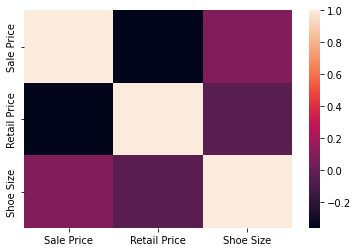

In [9]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns,
    yticklabels=corr.columns)

We can see that Sale Price and Retail Price have a very stong correlation each other. Therefore it could be intersting to merge this features. The result of this operation give us the Profit for each sale. 

In [10]:
df["Profit"] = df['Sale Price'] - df['Retail Price']

A other factor that we must take into account is the correlation between Retail Price and Shoe Size. In fact, as we can see below price evolves according this features.

In [11]:
df[['Sale Price', 'Shoe Size']].groupby(['Shoe Size']).mean().sort_values(by='Sale Price', ascending = False).head(5)

,Sale Price
Shoe Size,
17.0,1189.000000
16.0,751.721519
15.0,670.130769
3.5,503.750000
10.0,477.032813


#### What kind of relationship do we have between categorical data ?

Now that we have studied the numerical correlations in our data, we can move on to our categorical data. In order to do this, i copy my actual dataset into a new one and i drop manualy my non-categorical columns.

In [15]:
df_categorical = df.copy()
df_categorical = df_categorical.drop(columns=["Sale Price", "Retail Price", "Shoe Size", "Profit"])

To be able to process data non-numerical data we need to numerise value. Pour pouvoir traiter nos données non numérique nous devons passer par une étape de numérisation.

In [17]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
for x in df_categorical.columns.values:
    df_categorical[x] = ordinal_encoder.fit_transform(df_categorical[[x]])

This give us the following result.

In [18]:
df_categorical.head()

,Order Date,Brand,Sneaker Name,Release Date,Buyer Region
0,0.0,0.0,5.0,5.0,4.0
1,0.0,0.0,8.0,6.0,4.0
2,0.0,0.0,9.0,6.0,4.0
3,0.0,0.0,10.0,6.0,17.0
4,0.0,0.0,11.0,8.0,39.0


Then we can implemente Cramér's V measurement."*In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1. It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946.*"(Wikipedia) 

In [19]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [20]:
columns = df_categorical.columns
corr_categorical = pd.DataFrame(index=columns, columns=columns)
for i in range(0,len(columns)):
    for j in range(i,len(columns)):
        cell = cramers_v(df_categorical[columns[i]], df_categorical[columns[j]])
        corr_categorical[columns[i]][columns[j]] = cell
        corr_categorical[columns[j]][columns[i]] = cell

In [24]:
corr_categorical.head()

,Order Date,Brand,Sneaker Name,Release Date,Buyer Region
Order Date,1.0,0.364982,0.268591,0.319404,0.043492
Brand,0.364982,0.999975,0.99976,0.999835,0.077983
Sneaker Name,0.268591,0.99976,1.0,0.999925,0.042972
Release Date,0.319404,0.999835,0.999925,1.0,0.050853
Buyer Region,0.043492,0.077983,0.042972,0.050853,1.0


In [ ]:
df['Profit'] = df['Sale Price'] -  df['Retail Price']

In [ ]:
df.describe()

#### Statistical description of our categorical values 

In [ ]:
df.describe(include=['O'])

## Clean data

### Checking the missing  values

In [ ]:
df.isnull().sum()

## Convert data type

In [ ]:
df.dtypes

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])

In [ ]:
df['Sale Price'] = df['Sale Price'].map(lambda x: x[1:].replace(',', '')).astype(float)
df['Retail Price'] = df['Retail Price'].map(lambda x: x[1:].replace(',', '')).astype(float)

In [ ]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# df["Buyer Region"] = ordinal_encoder.fit_transform(df[["Buyer Region"]])


In [ ]:
df.head()

In [ ]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


In [ ]:
df.describe()

In [ ]:
df.describe(include=['O'])

In [ ]:
df[['Sale Price', 'Shoe Size']].groupby(['Shoe Size']).mean().sort_values(by='Sale Price', ascending = False)

In [ ]:
df_Region_count = df[['Sale Price', 'Buyer Region']].groupby(['Buyer Region']).count().sort_values(by='Sale Price', ascending = False)
df_Region_mean = df[['Sale Price', 'Buyer Region']].groupby(['Buyer Region']).mean().sort_values(by='Sale Price', ascending = False)
pd.concat([df_Region_count, df_Region_mean], axis=1, join="inner")

In [ ]:
sns.displot(data=df, x="Shoe Size", kde=True)
# g = sns.FacetGrid(df, col ='Shoe Size')
# g.map(plt.hist, 'Sale Price', bins=20)
#df[['Sale Price', 'Shoe Size']].groupby(['Shoe Size']).count().sort_values(by='Sale Price', ascending = True)
#df[['Shoe Size', '']].groupby(['Shoe Size']).count()

## Exploratory Data Analysis 

In [ ]:
df['Profit'] = df["Sale Price"] - df["Retail Price"]